import sklearn
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
# Clinical Deterioration Prediction Model - Logistic Regression
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

## Data

The final dataset used for the inferential statistics project includes unique ICU admission of 46,234 patients’ demographic (age), vital (blood pressure, heart rate, body temperature, and Glasgow Comma Scale), underlying conditions (HIV, metastatic cancer, and hematologic malignancy), admission type (scheduled surgical, medical, or unscheduled surgical), renal (urinary output, and Blood Urea Nitrogen), and others (serum bicarbonate level, sodium level, potassium level, and bilirubin level) data. This dataset is build based on the commonly used mortality prediction tool, Simplified Acute Physiology Score II (SAPSII).

In [1]:
os.getcwd()

<IPython.core.display.Javascript object>

'C:\\Users\\abebu\\Dropbox\\Data Science\\Projects\\Capstone Project 1\\Potential Projects\\9. MIMIC\\Machine Learning\\Clinical-Deterioration-Prediction-Model--Logistic-Regression'

In [2]:
os.chdir("C://Users/abebu/Google Drive/mimic-iii-clinical-database-1.4")

<IPython.core.display.Javascript object>

In [7]:
saps = pd.read_csv("saps_ts.csv", header=0, index_col=0)
saps.head()

<IPython.core.display.Javascript object>

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,los,hdeath,death,admission,ud,bun,Bicarbonate,...,Sodium,Temp,Bilirubin,WBC,hr,gcs,bp,AGE,UO,saps2
0,268,110404,280836,3.2490,1,1,8,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,11.0,26.0,13.0,12.0,0.0,82.0
1,269,106296,206613,3.2788,0,0,8,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0,37.0
2,270,188028,220345,2.8939,0,0,0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,11.0,0.0,13.0,18.0,0.0,45.0
3,271,173727,249196,2.0600,0,0,8,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0
4,272,164716,210407,1.6202,0,0,8,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,5.0,12.0,0.0,28.0


In [9]:
saps = pd.get_dummies(saps, columns=['Potassium', 'Sodium',
                                           'WBC', 'hr', 'bp']) 

<IPython.core.display.Javascript object>

In [10]:
saps.to_csv('saps_ts.csv')

First, run logistics regression using saps2 (the sum of all features) as explantory variable and death at ICU (hdeath - hospital death) as target variable. 

In [12]:
# Create arrays for features and target variable
y = saps['hdeath'].values
X = saps['saps2'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
#y = y.reshape(-1, 1)
X = X.reshape(-1, 1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (61117,)
Dimensions of X before reshaping: (61117,)
Dimensions of y after reshaping: (61117,)
Dimensions of X after reshaping: (61117, 1)



* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y,random_state=5)

clf = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)

# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(clf.predict(Xlr), ylr))))
print('Testing Accuracy: {}'.format((accuracy_score(clf.predict(Xtestlr), ytestlr))))


Training Accuracy: 0.9077164735912037
Testing Accuracy: 0.9036649214659686


### Hyperparameter Tuning 

The model has some hyperparameters we can tune for hopefully better performance.  In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. Note that the regularization parameter is not always part of the logistic regression model. The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection. We may not need this for our model but worth checking. 


In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [15]:
clf = LogisticRegression(solver='lbfgs')
score = cv_score(clf, Xlr, ylr)
print(score)

0.9079345258458951


Using the `cv_score` function (5-fold cross validation) for a basic logistic regression model without regularization,the score on the held-out data (test data) is `0.908`, `91%`. 

In [16]:
#the grid of parameters to search over
Cs = [0.01, 0.1, 1, 10, 100]
max_score = 0
for c in Cs:
    clf=LogisticRegression(solver='lbfgs', C=c)
    score = cv_score(clf, Xlr, ylr)
    print(f'score: {score}, C:{c}')
    if score > max_score:
        max_score = score
        max_C = c
print(f'\nThe Maximum score with training data is {max_score} for a C value of {max_C}.')

score: 0.9079345258458951, C:0.01
score: 0.9079345258458951, C:0.1
score: 0.9079345258458951, C:1
score: 0.9079345258458951, C:10
score: 0.9079345258458951, C:100

The Maximum score with training data is 0.9079345258458951 for a C value of 0.01.


Based on the training set the best model parameter is 0.9079345258458951 for a C value of 0.01.

In [17]:
clf =LogisticRegression(solver='lbfgs', C=max_C)
# Fit the model on teh training data
clf.fit(Xlr, ylr)
# Print the accuracy from the test data
print(f'The accuracy with the test data is {accuracy_score(clf.predict(Xtestlr), ytestlr)} for a C value of {max_C}.')

The accuracy with the test data is 0.9036649214659686.


Running the model with C=0.01 gives as the same accuracy results on the test data as the deafult. This is not always the case hence important to experment with the hyperparameters that works best with new data. 

### Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(max_iter=1000)

# define parameter values
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(Xlr, ylr)

# summarize results
print(f"Best score on training data: {grid_result.best_score_} using {grid_result.best_params_}")

Best score on training data: 0.9080219037022492 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [19]:
print(f'Score on test data: {accuracy_score(grid_result.predict(Xtestlr), ytestlr)}')

Score on test data: 0.9044502617801047


It gives a diffrent best value of C - this time 0.1. The GridSearchCV performs slightly better on test data (0.9036 vs 0.9044), almost the same. 

Let's first set some code up for classification that we will need for further discussion on the math. We first set up a function `cv_optimize` which takes a classifier `clf`, a grid of hyperparameters (such as a complexity parameter or regularization parameter) implemented as a dictionary `parameters`, a training set (as a samples x features array) `Xtrain`, and a set of labels `ytrain`. The code takes the traning set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and retuens the best classifier to us.

In [20]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

We then use this best classifier to fit the entire training set. This is done inside the `do_classify` function which takes a dataframe `indf` as input. It takes the columns in the list `featurenames` as the features used to train the classifier. The column `targetname` sets the target. The classification is done by setting those samples for which `targetname` has value `target1val` to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired. (Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation. We then train the model on the training set using cross-validation. Having obtained the best classifier using `cv_optimize`, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

In [21]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [22]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(solver='lbfgs'), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           saps, ['saps2'], 'hdeath',1)

<IPython.core.display.Javascript object>

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.91
Accuracy on test data:     0.90


### Standardize

In [100]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=True, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [101]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(solver='lbfgs'), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           saps, ['saps2'], 'hdeath',1)

<IPython.core.display.Javascript object>

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.91
Accuracy on test data:     0.91


### ROC Curve
`Plotting an ROC curve - receiver operating characteristic `

In [24]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], 'o-', alpha=0.8, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.8, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.1,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

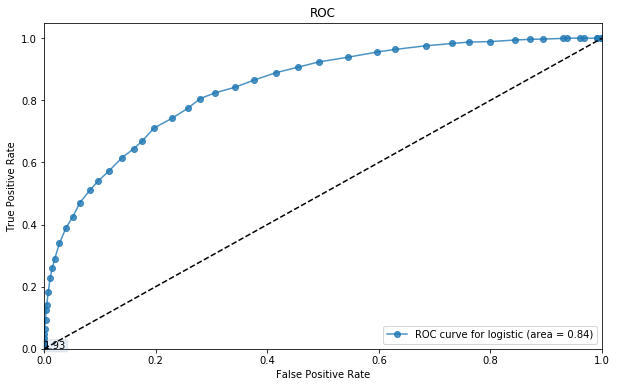

In [25]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,6))
ax=make_roc("logistic", clf_l, ytest_l, Xtest_l, labe=200, skip=2)

### Cross Validation Score

we should evaluate the performance of an algorithm rigorously by using resampling approaches (e.g. 100 times 5-fold cross-validation) to get some measurement of the variability in the performance of the algorithm. Maybe on a particular hold-out set, two algorithms have very similar performance but the variability of their estimates is massively different. That has serious implication on when we deploy our model in the future or use it to draw conclusion about future performance.

In [26]:
# Import necessary modules
from sklearn.model_selection import cross_val_score

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_l, Xtest_l, ytest_l.ravel(), cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.84631633 0.81585015 0.85512388 0.85891427 0.84046901]


Run class_weight 

In [29]:
list(saps.columns)

['SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'los',
 'hdeath',
 'death',
 'admission',
 'ud',
 'bun',
 'Bicarbonate',
 'ventilation',
 'Temp',
 'Bilirubin',
 'gcs',
 'AGE',
 'UO',
 'saps2',
 'Potassium_0.0',
 'Potassium_3.0',
 'Sodium_0.0',
 'Sodium_1.0',
 'Sodium_5.0',
 'WBC_0.0',
 'WBC_3.0',
 'hr_0.0',
 'hr_2.0',
 'hr_4.0',
 'hr_7.0',
 'hr_11.0',
 'bp_0.0',
 'bp_2.0',
 'bp_5.0',
 'bp_13.0']

In [59]:
# Create arrays for features and target variable
y = saps['hdeath'].values
X = saps[['admission',
 'ud',
 'bun',
 'Bicarbonate',
 'ventilation',
 'Temp',
 'Bilirubin',
 'gcs',
 'AGE',
 'UO',
 'Potassium_0.0',
 'Potassium_3.0',
 'Sodium_0.0',
 'Sodium_1.0',
 'Sodium_5.0',
 'WBC_0.0',
 'WBC_3.0',
 'hr_0.0',
 'hr_2.0',
 'hr_4.0',
 'hr_7.0',
 'hr_11.0',
 'bp_0.0',
 'bp_2.0',
 'bp_5.0',
 'bp_13.0']].values
# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1, 1)
#X = X.reshape(-1, 1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))



Dimensions of y before reshaping: (61117,)
Dimensions of X before reshaping: (61117, 26)
Dimensions of y after reshaping: (61117, 1)
Dimensions of X after reshaping: (61117, 26)


In [62]:
# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y.ravel(),random_state=5)

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)

# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(clf.predict(Xlr), ylr))))
print('Testing Accuracy: {}'.format((accuracy_score(clf.predict(Xtestlr), ytestlr))))


Training Accuracy: 0.9216135436437812
Testing Accuracy: 0.918913612565445


In [64]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [66]:
y

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [44]:
saps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61117 entries, 0 to 61116
Data columns (total 33 columns):
SUBJECT_ID       61117 non-null int64
HADM_ID          61117 non-null int64
ICUSTAY_ID       61117 non-null int64
los              61117 non-null float64
hdeath           61117 non-null int64
death            61117 non-null int64
admission        61117 non-null int64
ud               61117 non-null float64
bun              61117 non-null float64
Bicarbonate      61117 non-null float64
ventilation      61117 non-null float64
Temp             61117 non-null float64
Bilirubin        61117 non-null float64
gcs              61117 non-null float64
AGE              61117 non-null float64
UO               61117 non-null float64
saps2            61117 non-null float64
Potassium_0.0    61117 non-null int64
Potassium_3.0    61117 non-null int64
Sodium_0.0       61117 non-null int64
Sodium_1.0       61117 non-null int64
Sodium_5.0       61117 non-null int64
WBC_0.0          61117 non-null i

In [42]:
saps['Potassium_0.0'] = saps['Potassium_0.0'].astype(np.int64)
saps['Potassium_3.0'] = saps['Potassium_3.0'].astype(np.int64)
saps['Sodium_0.0'] = saps['Sodium_0.0'].astype(np.int64)
saps['Sodium_1.0'] = saps['Sodium_1.0'].astype(np.int64)
saps['Sodium_5.0'] = saps['Sodium_5.0'].astype(np.int64)
saps['WBC_0.0'] = saps['WBC_0.0'].astype(np.int64)
saps['WBC_3.0'] = saps['WBC_3.0'].astype(np.int64)
saps['hr_0.0'] = saps['hr_0.0'].astype(np.int64)
saps['hr_2.0'] = saps['hr_2.0'].astype(np.int64)
saps['hr_4.0'] = saps['hr_4.0'].astype(np.int64)
saps['hr_7.0'] = saps['hr_7.0'].astype(np.int64)
saps['hr_11.0'] = saps['hr_11.0'].astype(np.int64)
saps['bp_0.0'] = saps['bp_0.0'].astype(np.int64)
saps['bp_2.0'] = saps['bp_2.0'].astype(np.int64)
saps['bp_5.0'] = saps['bp_5.0'].astype(np.int64)
saps['bp_13.0'] = saps['bp_13.0'].astype(np.int64)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
score = cv_score(clf, Xlr, ylr)
print(score)

0.9214825696009912


In [68]:
#the grid of parameters to search over
Cs = [0.01, 0.1, 1, 10, 100]
max_score = 0
for c in Cs:
    clf=LogisticRegression(solver='lbfgs', max_iter=1000, C=c)
    score = cv_score(clf, Xlr, ylr)
    print(f'score: {score}, C:{c}')
    if score > max_score:
        max_score = score
        max_C = c
print(f'\nThe Maximum score with training data is {max_score} for a C value of {max_C}.')

score: 0.921002639409019, C:0.01
score: 0.9214171293342783, C:0.1
score: 0.9214825696009912, C:1
score: 0.9215043846097171, C:10
score: 0.9215262019981758, C:100

The Maximum score with training data is 0.9215262019981758 for a C value of 100.


In [70]:
clf =LogisticRegression(solver='lbfgs', max_iter=1000, C=max_C)
# Fit the model on teh training data
clf.fit(Xlr, ylr)
# Print the accuracy from the test data
print(f'The accuracy with the test data is {accuracy_score(clf.predict(Xtestlr), ytestlr)}.')

The accuracy with the test data is 0.919044502617801.


In [71]:
model = LogisticRegression(max_iter=1000)

# define parameter values
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(Xlr, ylr)

# summarize results
print(f"Best score on training data: {grid_result.best_score_} using {grid_result.best_params_}")

Best score on training data: 0.9215480943342714 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [72]:
print(f'Score on test data: {accuracy_score(grid_result.predict(Xtestlr), ytestlr)}')

Score on test data: 0.918782722513089


In [73]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [74]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [80]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(solver='lbfgs', max_iter=2000), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           saps, ['admission',
 'ud',
 'bun',
 'Bicarbonate',
 'ventilation',
 'Temp',
 'Bilirubin',
 'gcs',
 'AGE',
 'UO',
 'Potassium_0.0',
 'Potassium_3.0',
 'Sodium_0.0',
 'Sodium_1.0',
 'Sodium_5.0',
 'WBC_0.0',
 'WBC_3.0',
 'hr_0.0',
 'hr_2.0',
 'hr_4.0',
 'hr_7.0',
 'hr_11.0',
 'bp_0.0',
 'bp_2.0',
 'bp_5.0',
 'bp_13.0'], 'hdeath',1)

<IPython.core.display.Javascript object>

BEST PARAMS {'C': 10}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


In [76]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], 'o-', alpha=0.8, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.8, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.1,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

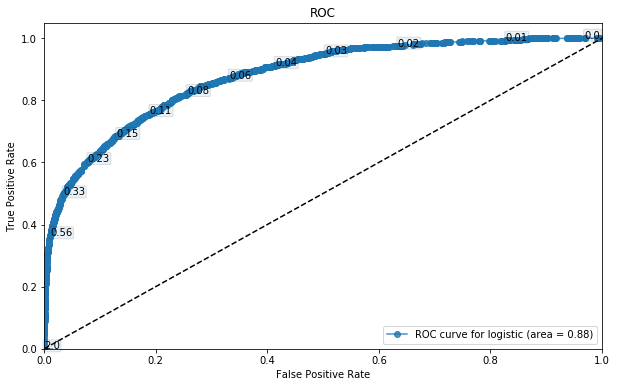

In [81]:
plt.figure(figsize=(10,6))
ax=make_roc("logistic", clf_l, ytest_l, Xtest_l, labe=200, skip=2)

In [79]:
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_l, Xtest_l, ytest_l.ravel(), cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.86265553 0.88734978 0.86138377 0.87400611 0.85694651]


In [ ]:
#standard scaling 
# xgboost
#



### Weighted Logistic Regression for Imbalanced Dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

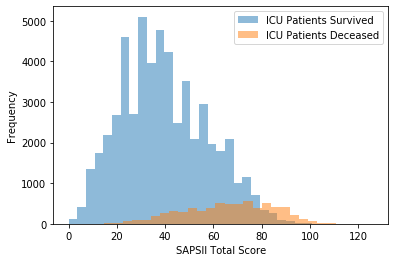

In [90]:
survived=saps.saps2.loc[saps.hdeath==0]
deceased=saps.saps2.loc[saps.hdeath==1]

_ = plt.hist(survived, bins=30, alpha=0.5, label='ICU Patients Survived')
_ = plt.hist(deceased, bins=30, alpha=0.5, label='ICU Patients Deceased')
_ = plt.xlabel('SAPSII Total Score')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [95]:
# Generate the confusion matrix and classification report
# Import necessary modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
ypred = clf.predict(Xtestlr)
# Generate the confusion matrix and classification report
print(confusion_matrix(ytestlr, ypred))
print(classification_report(ytestlr, ypred))

[[13384   199]
 [ 1038   659]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     13583
           1       0.77      0.39      0.52      1697

    accuracy                           0.92     15280
   macro avg       0.85      0.69      0.74     15280
weighted avg       0.91      0.92      0.91     15280



In [98]:
from sklearn.metrics import roc_auc_score, recall_score

# define class weights (11%, 89%)
w = {0:89, 1:11}

# define model
clf2 = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight=w)
# fit
clf2.fit(Xlr,ylr)
# test
ypred = clf2.predict(Xtestlr)
# performance
print(f'Accuracy Score: {accuracy_score(ytestlr,ypred)}')
print(confusion_matrix(ytestlr, ypred))
print(classification_report(ytestlr, ypred))
print(f'Area Under Curve: {roc_auc_score(ytestlr, ypred)}')
print(f'Recall score: {recall_score(ytestlr,ypred)}')

Accuracy Score: 0.9013089005235602
[[13567    16]
 [ 1492   205]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     13583
           1       0.93      0.12      0.21      1697

    accuracy                           0.90     15280
   macro avg       0.91      0.56      0.58     15280
weighted avg       0.90      0.90      0.87     15280

Area Under Curve: 0.5598117356217265
Recall score: 0.12080141426045964


### XGBoost 

XGBoost Python api provides a method to assess the incremental performance by the incremental number of trees. It uses two arguments: “eval_set” — usually Train and Test sets — and the associated “eval_metric” to measure your error on these evaluation sets.

In [87]:
from xgboost import XGBClassifier
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=1)

In [89]:

eval_set = [(Xlr, ylr), (Xtestlr, ytestlr)]
eval_metric = ["auc", "error"]
%time model.fit(Xlr, ylr, eval_metric=eval_metric, eval_set=eval_set, verbose=True)



[0]	validation_0-auc:0.805756	validation_0-error:0.083622	validation_1-auc:0.809636	validation_1-error:0.087631
[1]	validation_0-auc:0.806417	validation_0-error:0.083535	validation_1-auc:0.806968	validation_1-error:0.087696
[2]	validation_0-auc:0.833609	validation_0-error:0.083535	validation_1-auc:0.83371	validation_1-error:0.087565
[3]	validation_0-auc:0.847123	validation_0-error:0.082968	validation_1-auc:0.848982	validation_1-error:0.086976
[4]	validation_0-auc:0.841802	validation_0-error:0.082968	validation_1-auc:0.842443	validation_1-error:0.086322
[5]	validation_0-auc:0.843148	validation_0-error:0.082902	validation_1-auc:0.844063	validation_1-error:0.086846
[6]	validation_0-auc:0.85287	validation_0-error:0.083535	validation_1-auc:0.854493	validation_1-error:0.087696
[7]	validation_0-auc:0.852881	validation_0-error:0.083557	validation_1-auc:0.85407	validation_1-error:0.087107
[8]	validation_0-auc:0.854487	validation_0-error:0.08347	validation_1-auc:0.854802	validation_1-error:0.087

[73]	validation_0-auc:0.870112	validation_0-error:0.086437	validation_1-auc:0.869796	validation_1-error:0.089921
[74]	validation_0-auc:0.870304	validation_0-error:0.086524	validation_1-auc:0.869977	validation_1-error:0.089856
[75]	validation_0-auc:0.870106	validation_0-error:0.086349	validation_1-auc:0.869769	validation_1-error:0.089921
[76]	validation_0-auc:0.870013	validation_0-error:0.085979	validation_1-auc:0.869659	validation_1-error:0.089529
[77]	validation_0-auc:0.869817	validation_0-error:0.086306	validation_1-auc:0.869416	validation_1-error:0.089921
[78]	validation_0-auc:0.869962	validation_0-error:0.085695	validation_1-auc:0.869603	validation_1-error:0.089398
[79]	validation_0-auc:0.870129	validation_0-error:0.085455	validation_1-auc:0.869848	validation_1-error:0.089202
[80]	validation_0-auc:0.869945	validation_0-error:0.085477	validation_1-auc:0.869671	validation_1-error:0.089267
[81]	validation_0-auc:0.870049	validation_0-error:0.085586	validation_1-auc:0.869803	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)